In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib notebook

Загрузим и проанализируем данные

In [2]:
data = pd.read_csv('RDC_samples/train.csv')

In [3]:
data.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,10.0.151.43,10.0.16.14,TCP,1026,"8000 > 63774 [PSH, ACK] Seq=1 Ack=1 Win=229 ..."
1,2,0.000004,10.0.151.43,10.0.16.14,TCP,1026,"[TCP Retransmission] 8000 > 63774 [PSH, ACK]..."
2,3,0.000019,10.0.4.66,10.0.17.129,TCP,70,445 > 36384 [ACK] Seq=1 Ack=1 Win=2573 Len=0...
3,4,0.000021,10.0.4.66,10.0.17.129,TCP,70,[TCP Dup ACK 3#1] 445 > 36384 [ACK] Seq=1 Ac...
4,5,0.000055,10.0.16.14,10.0.151.43,TCP,64,63774 > 8000 [ACK] Seq=1 Ack=1 Win=4096 Len=0


In [4]:
data.Protocol.count()

269306

In [5]:
data.Protocol.loc[data.Protocol == 'TCP'].count()

269306

In [6]:
data.Info.apply(lambda x: x.find('Win') != -1).count()

269306

Распарсим колонку Info и оцифруем Ip адреса 

In [7]:
def parse_data(par_list):
    par_list = par_list.split()

    if not par_list[0].isdigit():
        counter = 0
        while not par_list[counter].isdigit():
            counter+=1        
        par_list = par_list[counter:]

    source_port = int(par_list[0])
    destination_port = int(par_list[2])
    windows_size_val = 0

    for it in par_list:
        if it.find('Win')!=-1:
            windows_size_val = int(it[4:])
            break
    return [source_port, destination_port, windows_size_val]

In [8]:
def data_init(file_name='train.csv'):
    data = pd.read_csv('RDC_samples/'+file_name)
    data['params'] = data.Info.apply(parse_data)
    data[['source_port', 'destination_port', 'windows_size_val']] = pd.DataFrame(data.params.tolist(), index=data.index)
    data = data.drop(columns=['params', 'Info', 'Protocol', 'Time', 'No.'])
    data.Source = data.Source.apply(lambda x: int(x.replace('.', '')) if x.replace('.', '').isdigit() else None)
    data.Destination = data.Destination.apply(lambda x: int(x.replace('.', '')) if x.replace('.', '').isdigit() else None)
    return data

In [9]:
data = data_init('train.csv')

In [10]:
data.head()

,Source,Destination,Length,source_port,destination_port,windows_size_val
0,10015143,1001614,1026,8000,63774,229
1,10015143,1001614,1026,8000,63774,229
2,100466,10017129,70,445,36384,2573
3,100466,10017129,70,445,36384,2573
4,1001614,10015143,64,63774,8000,4096


Посмотрим сколько уникальных элементов и построим гистограммы, чтобы понять, какие элементы считать аномалиями

In [11]:
data.nunique()

Source               31
Destination          40
Length              497
source_port         162
destination_port     90
windows_size_val    607
dtype: int64

<IPython.core.display.Javascript object>


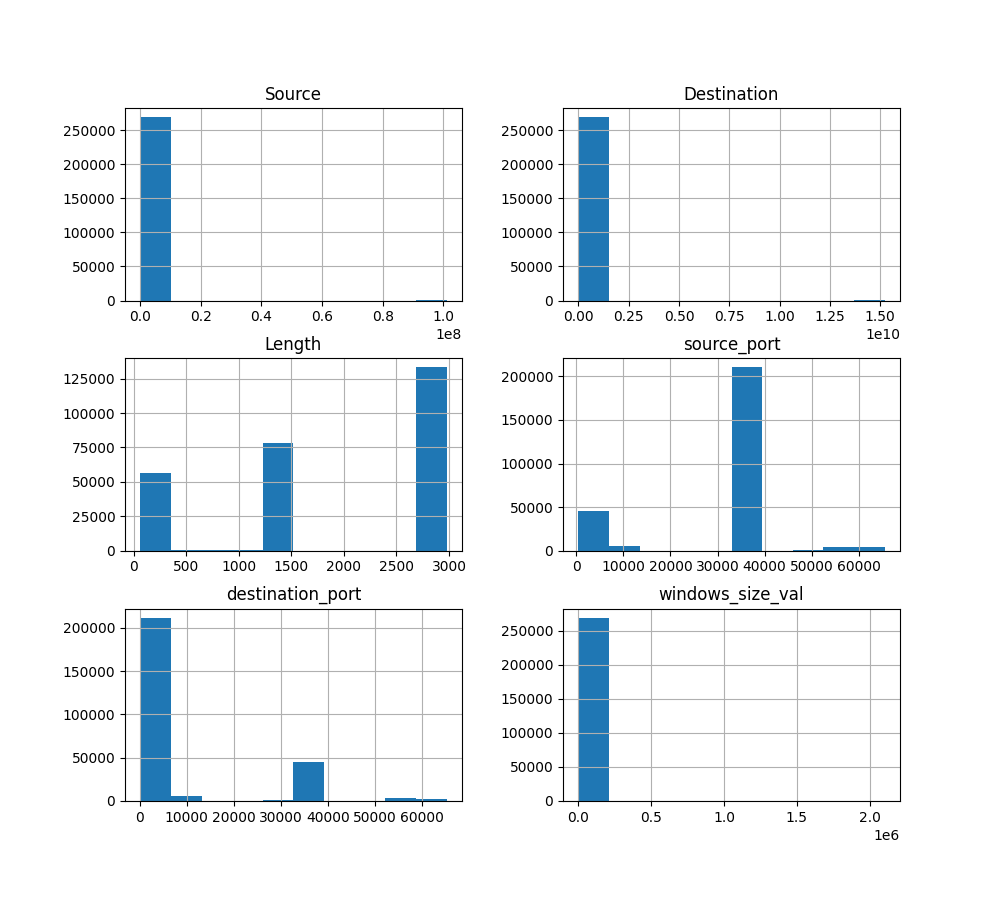

array([[<AxesSubplot:title={'center':'Source'}>,
        <AxesSubplot:title={'center':'Destination'}>],
       [<AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'source_port'}>],
       [<AxesSubplot:title={'center':'destination_port'}>,
        <AxesSubplot:title={'center':'windows_size_val'}>]], dtype=object)

In [12]:
data.hist(figsize=(10, 9))

<IPython.core.display.Javascript object>


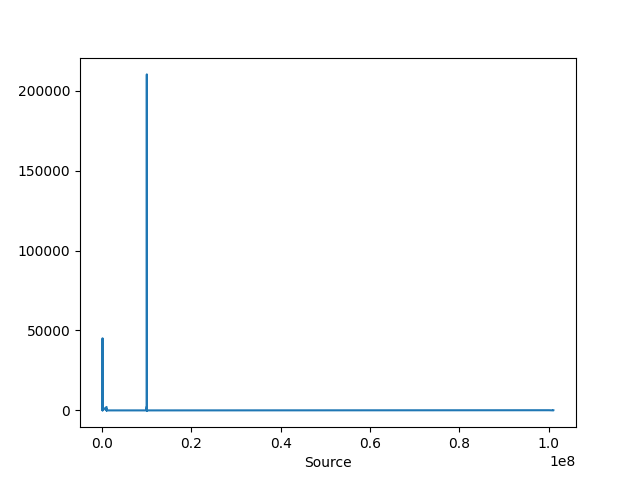

<AxesSubplot:xlabel='Source'>

In [13]:
plt.figure()
data.groupby('Source').Destination.count().rename({'Destination':'count'}).plot()

Создадим полносвязную нейронную сеть, задачей которой будет на выходе давать результат схожий с тем, что был на входе, тогда при наличии аномалий, нейронная сеть будет давать большую ошибку, что можно будет отследить

In [14]:
import torch
from torch import nn

In [15]:
X = torch.FloatTensor(np.asarray(data))

In [16]:
train_data_size = int(0.8*X.shape[0])
X_train, X_val = X[:train_data_size], X[train_data_size:]

In [17]:
X_train.shape

torch.Size([215444, 6])

In [18]:
X_val.shape

torch.Size([53862, 6])

In [19]:
features_count = X_train.shape[1]
rows = X_train.shape[0]
learning_rate = 1e-3
batch_size = 700
epochs = 5

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [21]:
model = nn.Sequential(
    nn.Linear(features_count, 32),
    nn.ReLU(),
    nn.Linear(32,48),
    nn.ReLU(),
    nn.Linear(48,64),
    nn.ReLU(),
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,features_count)
)
model.to(device)

Sequential(
  (0): Linear(in_features=6, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=48, bias=True)
  (3): ReLU()
  (4): Linear(in_features=48, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=6, bias=True)
)

In [22]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
loss_history = []
for epoch in range(epochs):
    for b_num in range(rows//batch_size):
        batch_X = X_train[b_num*batch_size:(b_num+1)*batch_size]
        batch_X = batch_X.to(device)
        pred = model.forward(batch_X)
        loss = criterion(pred, batch_X)
        loss_history.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss_history[-1])

30144.064453125
27260.58984375
40866.19140625
37049.25
27651.134765625


<IPython.core.display.Javascript object>


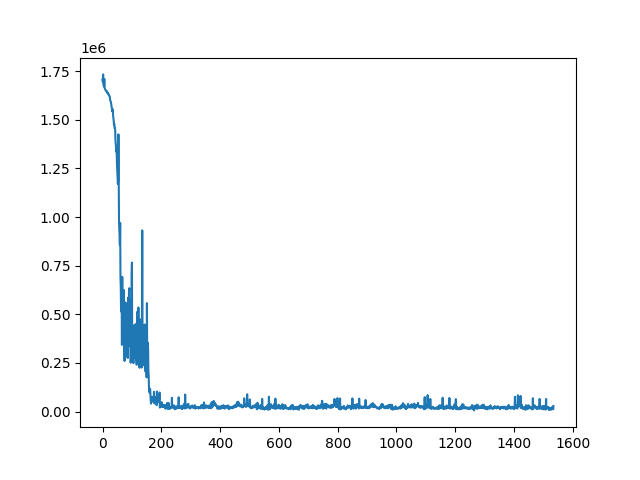

In [24]:
plt.figure()
plt.plot(loss_history)

In [25]:
loss_history[-1]

27651.134765625

Осталась достаточно большая ошибка, но при этом она стабильная, то есть если в данных будут аномалии, то ошибка, предположительно, будет гораздо больше

Сделаем прямой проход на валидационных данных и найдем l1 метрику для каждого элемента

In [26]:
def predict(X_to_pred):
    with torch.no_grad():
        rows = X_to_pred.shape[0]
        predictions = np.array([[0]*features_count])
        for b_num in range(rows//batch_size):
            batch_X = X_to_pred[b_num*batch_size:(b_num+1)*batch_size]
            pred = np.asarray(model.forward(batch_X))
            predictions = np.vstack((predictions, pred))
        batch_X = X_to_pred[(rows//batch_size)*batch_size:]
        pred = np.asarray(model.forward(batch_X))
        predictions = np.vstack((predictions, pred))
    return predictions[1:]

In [27]:
model.cpu()
preds = predict(X_val)
preds

array([[ 9.89114375e+04,  1.00386560e+07, -3.63371191e+03,
        -1.31043662e+04,  4.45131094e+04,  6.37643616e+02],
       [ 9.89114375e+04,  1.00386560e+07, -3.63371191e+03,
        -1.31043662e+04,  4.45131094e+04,  6.37643616e+02],
       [ 9.87401250e+04,  1.00367560e+07, -3.62421191e+03,
        -1.31321787e+04,  4.45097344e+04,  6.40581116e+02],
       ...,
       [ 9.85929300e+06,  7.57521250e+04, -1.04373682e+04,
         3.06654141e+04, -2.50317012e+04, -1.07395470e+02],
       [ 9.85929300e+06,  7.57521250e+04, -1.04373682e+04,
         3.06654141e+04, -2.50317012e+04, -1.07395470e+02],
       [ 9.85966200e+06,  7.57511250e+04, -1.04389932e+04,
         3.06564141e+04, -2.50342012e+04, -1.11356407e+02]])

In [28]:
preds.shape

(53862, 6)

In [29]:
X_val_tmp = np.asarray(X_val)
losses = np.sum(np.abs(X_val_tmp - preds),axis=1)
print(losses.shape)


(53862,)


<IPython.core.display.Javascript object>


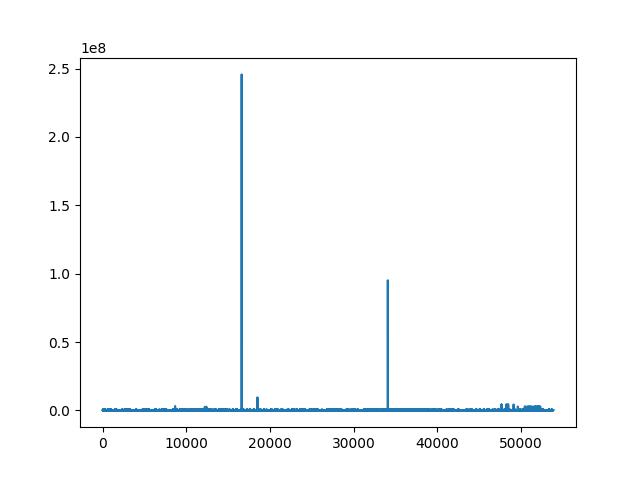

In [30]:
plt.figure()
plt.plot(losses)

In [32]:
losses = pd.Series(losses)
losses.loc[losses > 0.5*1e8]

16615    2.457650e+08
16616    2.457650e+08
34073    9.520628e+07
34074    9.520628e+07
dtype: float64

Нашли индексы элементов из первоначального датасета которые модель посчитала аномалиями
Заметим, что на обучающих данных ошибка была не такая стабильная как на валидационных, но при этом и аномалий заметно не было, потому что на тестовых данных считалась средняя ошибка на батче.

Проведем аналогичный анализ на первом тестовом датасете

In [84]:
test_data_1 = data_init('test_1.csv')

In [85]:
test_data_1.head()

,Source,Destination,Length,source_port,destination_port,windows_size_val
0,1004245,10016152,1518,3128,62408,513
1,1004245,10016152,2978,3128,62408,513
2,1004245,10016152,2978,3128,62408,513
3,1004245,10016152,2978,3128,62408,513
4,1004245,10016152,2973,3128,62408,513


In [86]:
test_data_1.isnull().sum()

Source              0
Destination         0
Length              0
source_port         0
destination_port    0
windows_size_val    0
dtype: int64

In [87]:
X_test = torch.FloatTensor(np.asarray(test_data_1))
X_test.shape

torch.Size([268378, 6])

In [88]:
preds = predict(X_test)
X_test_tmp = np.asarray(X_test)
losses = np.sum(np.abs(X_test_tmp - preds),axis=1)
print(losses.shape)

(268378,)


<IPython.core.display.Javascript object>


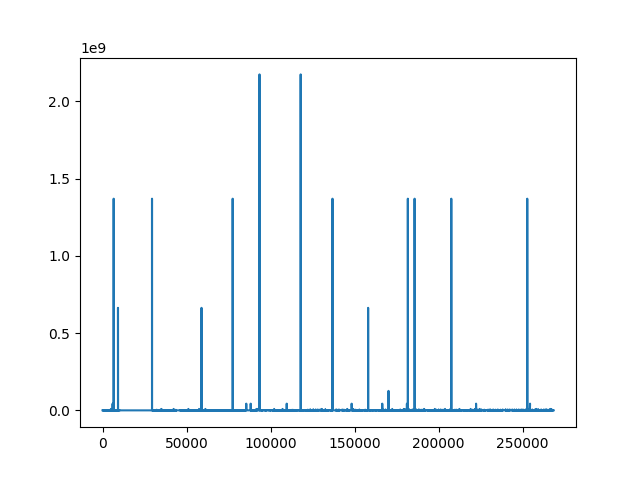

In [89]:
plt.figure()
plt.plot(losses)

In [90]:
losses = pd.Series(losses)
losses = losses.loc[losses > 0.4 * 1e9]

In [91]:
losses.index

Int64Index([  6618,   6619,   9190,   9191,  29443,  29444,  58902,  58903,
             77444,  77445,  93418,  93419, 117922, 117923, 136857, 136858,
            158076, 158077, 181706, 181707, 185724, 185725, 207565, 207566,
            252778, 252779],
           dtype='int64')

In [41]:
test_data_1_abnormal = test_data_1.loc[losses.index]

In [42]:
test_data_1_abnormal

,Source,Destination,Length,source_port,destination_port,windows_size_val
6618,10016139,82202185148,70,50624,443,64240
6619,10016139,82202185148,70,50624,443,64240
9190,10016139,40127240158,70,50623,443,64240
9191,10016139,40127240158,70,50623,443,64240
29443,10016139,82202185148,70,50624,443,64240
29444,10016139,82202185148,70,50624,443,64240
58902,10016139,40127240158,70,50623,443,64240
58903,10016139,40127240158,70,50623,443,64240
77444,10016139,82202185148,70,50624,443,64240
77445,10016139,82202185148,70,50624,443,64240


Проанализируем второй тестовый датасет

In [92]:
test_data_2 = data_init('test_2.csv')

In [93]:
test_data_2.isnull().sum()

Source              50
Destination         50
Length               0
source_port          0
destination_port     0
windows_size_val     0
dtype: int64

In [94]:
test_data_2 = test_data_2.dropna()

In [95]:
test_data_2.isnull().sum()

Source              0
Destination         0
Length              0
source_port         0
destination_port    0
windows_size_val    0
dtype: int64

<IPython.core.display.Javascript object>


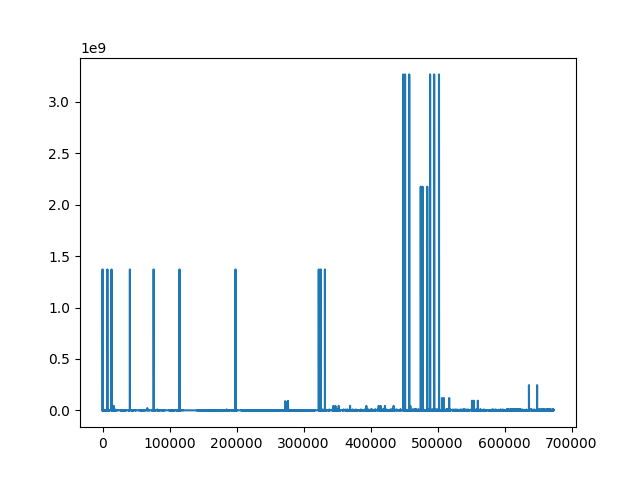

In [96]:
X_test = torch.FloatTensor(np.asarray(test_data_2))
preds = predict(X_test)
X_test_tmp = np.asarray(X_test)
losses = np.sum(np.abs(X_test_tmp - preds),axis=1)
plt.figure()
plt.plot(losses)

In [97]:
losses = pd.Series(losses)
losses = losses.loc[losses > 0.5 * 1e9]
losses.index

Int64Index([    15,   7212,   7213,  13390,  13391,  40809,  40810,  76226,
             76227, 114883, 114884, 198466, 198467, 322703, 322704, 325752,
            325753, 331905, 331906, 448512, 448513, 451528, 451529, 457740,
            457741, 474919, 474920, 477590, 477591, 484637, 484638, 488876,
            488877, 494964, 494965, 502165, 502166],
           dtype='int64')

In [66]:
test_data_2_abnormal = test_data_2.loc[losses.index]
test_data_2_abnormal

,Source,Destination,Length,source_port,destination_port,windows_size_val
15,10016140.0,8.220218e+10,70,55002,443,64240
7212,10016140.0,8.220218e+10,70,55003,443,64240
7213,10016140.0,8.220218e+10,70,55003,443,64240
13390,10016140.0,8.220218e+10,70,55003,443,64240
13391,10016140.0,8.220218e+10,70,55003,443,64240
40809,10016140.0,8.220218e+10,70,55003,443,64240
40810,10016140.0,8.220218e+10,70,55003,443,64240
76226,10016140.0,8.220218e+10,70,55004,443,64240
76227,10016140.0,8.220218e+10,70,55004,443,64240
114883,10016140.0,8.220218e+10,70,55004,443,64240


Проанализируем третий тестовый датасет

In [98]:
test_data_3 = data_init('test_3.csv')

In [99]:
test_data_3.isnull().sum()

Source              0
Destination         0
Length              0
source_port         0
destination_port    0
windows_size_val    0
dtype: int64

<IPython.core.display.Javascript object>


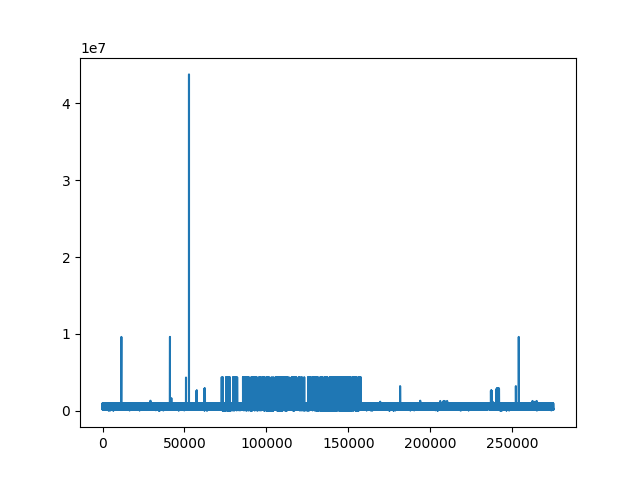

In [100]:
X_test = torch.FloatTensor(np.asarray(test_data_3))
preds = predict(X_test)
X_test_tmp = np.asarray(X_test)
losses = np.sum(np.abs(X_test_tmp - preds),axis=1)
plt.figure()
plt.plot(losses)

In [110]:
losses = pd.Series(losses)
losses = losses.loc[losses > 0.4 * 1e7]

In [119]:
with open('text_3.txt', 'w') as f:
    a = ','.join(list(map(str, losses.index)))
    f.write(a)

In [80]:
test_data_3_abnormal = test_data_3.loc[losses.index]
test_data_3_abnormal.head()

,Source,Destination,Length,source_port,destination_port,windows_size_val
11488,10108115,100109143,70,57986,13000,65535
11489,10108115,100109143,70,57986,13000,65535
41145,10108122,100112228,70,63396,13000,65535
41146,10108122,100112228,70,63396,13000,65535
50936,10026100,10017201,70,445,61858,4103
